In [1]:
pip install opencv-python mediapipe scikit-learn


   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   -- ------------------------------------- 2.9/39.5 MB 18.7 MB/s eta 0:00:02
   ------- -------------------------------- 7.3/39.5 MB 19.7 MB/s eta 0:00:02
   ---------- ----------------------------- 10.2/39.5 MB 18.2 MB/s eta 0:00:02
   ------------ --------------------------- 12.6/39.5 MB 16.4 MB/s eta 0:00:02
   ------------------- -------------------- 18.9/39.5 MB 18.3 MB/s eta 0:00:02
   --------------------------- ------------ 27.3/39.5 MB 22.1 MB/s eta 0:00:01
   ----------------------------------- ---- 35.4/39.5 MB 24.4 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 25.5 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 25.5 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 20.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/51.0 MB ? eta -:--:--
   ----- ---------------------------------- 7.6/51.0 MB 36.2 MB/s eta 0:

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda117 10.6.0 requires numpy<1.25,>=1.18, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.


In [ ]:
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import cv2
from sklearn.cluster import KMeans

# 顔検出用モデル
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def extract_all_thumbnail_features(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB").resize((128, 128))
        img_np = np.array(img)

        # 平均明度（グレースケール）
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        brightness = gray.mean()

        # 顔の数（OpenCV）
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        face_count = len(faces)

        # テロップっぽい領域（輪郭面積比）
        edges = cv2.Canny(gray, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        telop_area = sum(cv2.contourArea(cnt) for cnt in contours)
        telop_ratio = telop_area / (128 * 128)

        # 平均RGB
        r_mean, g_mean, b_mean = img_np[:, :, 0].mean(), img_np[:, :, 1].mean(), img_np[:, :, 2].mean()

        # 平均HSV
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        h_mean, s_mean, v_mean = hsv[:, :, 0].mean(), hsv[:, :, 1].mean(), hsv[:, :, 2].mean()

        # 色の多様性（クラスタリング）
        pixels = img_np.reshape(-1, 3)
        kmeans = KMeans(n_clusters=5, n_init=5).fit(pixels)
        hist, _ = np.histogram(kmeans.labels_, bins=np.arange(6))
        color_ratio = hist / hist.sum()

        return np.concatenate([
            [brightness, face_count, telop_ratio],
            [r_mean, g_mean, b_mean],
            [h_mean, s_mean, v_mean],
            color_ratio
        ])
    except:
        return np.full(3 + 3 + 3 + 5, np.nan)


In [3]:
import pandas as pd
from tqdm import tqdm

# サムネイルURLの列があるdfを読み込み
df = pd.read_excel("youtube_dataset.xlsx")

# 特徴量を一括抽出
features = np.array([extract_all_thumbnail_features(url) for url in tqdm(df["thumbnail"].fillna(""))])

# カラム名の定義
columns = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

feature_df = pd.DataFrame(features, columns=columns)

# 欠損補完（平均で）
feature_df = feature_df.fillna(feature_df.mean())

# dfに結合して保存 or 学習用に使う
df_full = pd.concat([df, feature_df], axis=1)
df_full.to_excel("youtube_dataset_with_thumbnails.xlsx", index=False)


100%|██████████████████████████████████████████| 502/502 [03:08<00:00,  2.67it/s]


In [1]:
df_full.head()

NameError: name 'df_full' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

# 📥 データ読み込み（df_full がすでにある前提）
df = df_full.copy()

# 🧠 目的変数をlog変換
df["log_view"] = np.log1p(df["viewCount"])
y = df["log_view"]

# 🔤 タイトルTF-IDF（100次元）
vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(df["title"].fillna("")).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f"tfidf_{t}" for t in vectorizer.get_feature_names_out()])
tfidf_df.index = df.index

# 🎨 サムネイル特徴量の列
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]
thumbnail_feature_df = df[thumbnail_cols]

# ✅ 特徴量の統合
X_new = pd.concat([
    df[["categoryId"]],
    tfidf_df,
    thumbnail_feature_df
], axis=1)

# ✂️ データ分割
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# 🌳 モデル構築・学習
model_new = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model_new.fit(X_train_new, y_train)

# 🔮 予測
y_pred_after = model_new.predict(X_test_new)

# 📊 評価（RMSE）
rmse_after = np.sqrt(mean_squared_error(y_test, y_pred_after))
print(f"✨ 新モデルのRMSE（logスケール）: {rmse_after:.4f}")
print(f"≒ 再生回数スケールでの誤差: ±{int(np.expm1(rmse_after)):,} 回")

# 🏆 重要な特徴量（上位10）
importances = model_new.feature_importances_
top_features = pd.Series(importances, index=X_new.columns).sort_values(ascending=False).head(10)
print("\n📊 重要な特徴量 TOP10：")
print(top_features)


In [21]:
from PIL import Image
import requests
from io import BytesIO
import cv2
from sklearn.cluster import KMeans
import numpy as np
from tqdm import tqdm

# 👤 顔検出モデル（OpenCV）
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def extract_all_thumbnail_features(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB").resize((128, 128))
        img_np = np.array(img)

        # グレースケール明度
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        brightness = gray.mean()

        # 顔検出
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        face_count = len(faces)

        # テロップっぽい面積（エッジ面積比）
        edges = cv2.Canny(gray, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        telop_area = sum(cv2.contourArea(c) for c in contours)
        telop_ratio = telop_area / (128 * 128)

        # RGB平均
        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()

        # HSV平均
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        # 主要色割合（KMeansクラスタリング）
        pixels = img_np.reshape(-1, 3)
        kmeans = KMeans(n_clusters=5, n_init=5).fit(pixels)
        hist, _ = np.histogram(kmeans.labels_, bins=np.arange(6))
        color_ratio = hist / hist.sum()

        return np.concatenate([
            [brightness, face_count, telop_ratio],
            [r_mean, g_mean, b_mean],
            [h_mean, s_mean, v_mean],
            color_ratio
        ])
    except:
        return np.full(14, np.nan)  # 欠損時は全NaN

# 🎯 一括抽出
print("🎨 サムネイル特徴量抽出中...")
features = np.array([
    extract_all_thumbnail_features(url) for url in tqdm(df["thumbnail"].fillna(""))
])

# 📊 カラム名定義
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# DataFrame化・欠損補完
thumbnail_feature_df = pd.DataFrame(features, columns=thumbnail_cols)
thumbnail_feature_df = thumbnail_feature_df.fillna(thumbnail_feature_df.mean())

# df に統合
df = pd.concat([df.reset_index(drop=True), thumbnail_feature_df.reset_index(drop=True)], axis=1)
print("✅ サムネイル特徴量を df に追加完了")


🎨 サムネイル特徴量抽出中...


100%|██████████████████████████████████████████| 304/304 [01:20<00:00,  3.79it/s]

✅ サムネイル特徴量を df に追加完了


In [22]:
print(df.columns)


Index(['videoId', 'title', 'description', 'publishedAt', 'categoryId', 'tags',
       'thumbnail', 'viewCount', 'likeCount', 'commentCount', 'duration',
       'duration_seconds', 'is_shorts', 'weekday', 'hour', 'is_weekend',
       'is_month_start', 'is_month_end', 'brightness', 'face_count',
       'telop_ratio', 'r_mean', 'g_mean', 'b_mean', 'h_mean', 's_mean',
       'v_mean', 'color_ratio_0', 'color_ratio_1', 'color_ratio_2',
       'color_ratio_3', 'color_ratio_4'],
      dtype='object')


In [23]:
# 🔁 サムネイル特徴量列名（すでに確認済み）
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# ⛓ 統合データ作成
thumbnail_feature_df = df[thumbnail_cols].reset_index(drop=True)

X_full = pd.concat([
    df[["categoryId"] + timing_cols].reset_index(drop=True),
    tfidf_df.reset_index(drop=True),
    thumbnail_feature_df
], axis=1)


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse


In [27]:
# 1. ベース特徴量
X_base = pd.concat([
    df[["categoryId"]].reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

# 2. 投稿タイミング付き
timing_cols = ["weekday", "hour", "is_weekend", "is_month_start", "is_month_end"]
X_ext = pd.concat([
    df[["categoryId"] + timing_cols].reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

# 3. サムネイル特徴量付き（X_full はすでに構築済み）

# 4. 評価関数（evaluate_model）は定義済み前提

rmse_base = evaluate_model(X_base, y)
rmse_ext = evaluate_model(X_ext, y)
rmse_full = evaluate_model(X_full, y)

# 5. 出力
print(f"📉 通常動画のみでのモデル精度比較（RMSE, logスケール）")
print(f"- TF-IDF + categoryId モデル：{rmse_base:.4f}")
print(f"- + 投稿タイミング拡張モデル：{rmse_ext:.4f}")
print(f"- + サムネイル画像特徴追加モデル：{rmse_full:.4f}")


📉 通常動画のみでのモデル精度比較（RMSE, logスケール）
- TF-IDF + categoryId モデル：0.8439
- + 投稿タイミング拡張モデル：0.8194
- + サムネイル画像特徴追加モデル：0.7662


In [28]:
# 顔の数とタイトルの一部を表示（例：10件）
display_columns = df[["face_count", "title"]].head(10)
print(display_columns.to_string(index=False))


 face_count                                                                           title
        0.0                       『よーいドン！』で全員同時に始めたらYouTube界の勢力図丸っきり変わるんじゃね？【始めるの早い奴ら勝ちゲー説】
        0.0                                                あきらをプロデュースのファーストテイクがとんでもない件について。
        0.0                                     【コムドット400万人突破/はじめしゃちょーの動画に物議/ヒカル酔っ払いに絡まれ負傷】
        0.0                                          ビジネスカップルYouTuber解散寸前の大喧嘩に遂に終止符が打たれました…
        0.0                                              で、かけまる結局どっちが悪いん？【遂に直接対決】【初見リアクション】
        0.0              会う度に「シルクさん以外には負けへんで」とイキってくるこたつは本当にスマブラ強いの？【YouTuberスマブラ大会初見リアクション】
        1.0                                  【かけまるなーちゃん本音を吐露/すするTV炎上/タケヤキ翔詐欺に遭う】みんなも気をつけよう。
        1.0 【ヒカルvsヴァンビ大喧嘩/閉園後のディズニーランドに隠れ炎上したYouTuber/1ヶ月後に復活する元大物YouTuber初見リアクション】内容が濃すぎる。
        1.0                                 【りゅうたドスからステパンへアンサー動画/マックスむらいAppBank退社】何度でも蘇る漢達。
        2.0                                               りゅうたドスがYouTube史上最速でオワコ

In [29]:
from PIL import Image
import requests
from io import BytesIO
import cv2
from sklearn.cluster import KMeans
import numpy as np
from tqdm import tqdm

# 📦 顔検出用のモデル（正面顔）
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def extract_all_thumbnail_features(url):
    try:
        # サムネ画像取得 & リサイズ
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB").resize((128, 128))
        img_np = np.array(img)

        # グレースケール画像
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # 🎯 顔検出（パラメータ調整済）
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.05,  # ← 小さい顔も検出しやすく
            minNeighbors=3     # ← 過検出気味でも取りこぼし減
        )
        face_count = len(faces)

        # ✏️ テロップ面積（エッジ比率）
        edges = cv2.Canny(gray, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        telop_area = sum(cv2.contourArea(c) for c in contours)
        telop_ratio = telop_area / (128 * 128)

        # 🎨 RGB平均
        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()

        # 🎨 HSV平均
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        # 🖼 色クラスタ（KMeans）
        pixels = img_np.reshape(-1, 3)
        kmeans = KMeans(n_clusters=5, n_init=5).fit(pixels)
        hist, _ = np.histogram(kmeans.labels_, bins=np.arange(6))
        color_ratio = hist / hist.sum()

        # 📊 明度
        brightness = gray.mean()

        return np.concatenate([
            [brightness, face_count, telop_ratio],
            [r_mean, g_mean, b_mean],
            [h_mean, s_mean, v_mean],
            color_ratio
        ])

    except Exception as e:
        # 欠損対応（14次元のNaN）
        return np.full(14, np.nan)


In [30]:
# df["thumbnail"] にURLが入っている前提
features = np.array([
    extract_all_thumbnail_features(url) for url in tqdm(df["thumbnail"].fillna(""))
])

# カラム名
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# DataFrame化 & 結合
thumbnail_feature_df = pd.DataFrame(features, columns=thumbnail_cols)
thumbnail_feature_df = thumbnail_feature_df.fillna(thumbnail_feature_df.mean())

df = pd.concat([df.reset_index(drop=True), thumbnail_feature_df.reset_index(drop=True)], axis=1)


100%|██████████████████████████████████████████| 304/304 [02:38<00:00,  1.92it/s]


In [31]:
# 顔の数とタイトルの一部を表示（例：10件）
display_columns = df[["face_count", "title"]].head(10)
print(display_columns.to_string(index=False))


 face_count  face_count                                                                           title
        0.0         0.0                       『よーいドン！』で全員同時に始めたらYouTube界の勢力図丸っきり変わるんじゃね？【始めるの早い奴ら勝ちゲー説】
        0.0         2.0                                                あきらをプロデュースのファーストテイクがとんでもない件について。
        0.0         0.0                                     【コムドット400万人突破/はじめしゃちょーの動画に物議/ヒカル酔っ払いに絡まれ負傷】
        0.0         0.0                                          ビジネスカップルYouTuber解散寸前の大喧嘩に遂に終止符が打たれました…
        0.0         0.0                                              で、かけまる結局どっちが悪いん？【遂に直接対決】【初見リアクション】
        0.0         0.0              会う度に「シルクさん以外には負けへんで」とイキってくるこたつは本当にスマブラ強いの？【YouTuberスマブラ大会初見リアクション】
        1.0         2.0                                  【かけまるなーちゃん本音を吐露/すするTV炎上/タケヤキ翔詐欺に遭う】みんなも気をつけよう。
        1.0         1.0 【ヒカルvsヴァンビ大喧嘩/閉園後のディズニーランドに隠れ炎上したYouTuber/1ヶ月後に復活する元大物YouTuber初見リアクション】内容が濃すぎる。
        1.0         1.0                                 【りゅうたドスか

In [32]:
pip install mediapipe opencv-python


Note: you may need to restart the kernel to use updated packages.


In [33]:
import mediapipe as mp
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from sklearn.cluster import KMeans

# Mediapipe FaceDetection 初期化
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

def extract_all_thumbnail_features_mediapipe(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB").resize((128, 128))
        img_np = np.array(img)

        # 📸 Mediapipeで顔検出（RGB形式で渡す）
        results = face_detector.process(img_np)
        face_count = len(results.detections) if results.detections else 0

        # 🎨 グレースケール明度
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        brightness = gray.mean()

        # 📝 テロップ面積比（エッジ比率）
        edges = cv2.Canny(gray, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        telop_area = sum(cv2.contourArea(c) for c in contours)
        telop_ratio = telop_area / (128 * 128)

        # 🎨 RGB平均
        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()

        # 🎨 HSV平均
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        # 🖼 色クラスタ（KMeans）
        pixels = img_np.reshape(-1, 3)
        kmeans = KMeans(n_clusters=5, n_init=5).fit(pixels)
        hist, _ = np.histogram(kmeans.labels_, bins=np.arange(6))
        color_ratio = hist / hist.sum()

        return np.concatenate([
            [brightness, face_count, telop_ratio],
            [r_mean, g_mean, b_mean],
            [h_mean, s_mean, v_mean],
            color_ratio
        ])
    except Exception as e:
        return np.full(14, np.nan)


In [34]:
from tqdm import tqdm

# 特徴量一括抽出（Mediapipe版）
features_mp = np.array([
    extract_all_thumbnail_features_mediapipe(url) for url in tqdm(df["thumbnail"].fillna(""))
])

# カラム名
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# DataFrame化・補完・結合
thumbnail_feature_df = pd.DataFrame(features_mp, columns=thumbnail_cols)
thumbnail_feature_df = thumbnail_feature_df.fillna(thumbnail_feature_df.mean())

df = pd.concat([df.reset_index(drop=True), thumbnail_feature_df.reset_index(drop=True)], axis=1)


100%|██████████████████████████████████████████| 304/304 [02:59<00:00,  1.69it/s]


In [35]:
# 顔の数とタイトルの一部を表示（例：10件）
display_columns = df[["face_count", "title"]].head(10)
print(display_columns.to_string(index=False))


 face_count  face_count  face_count                                                                           title
        0.0         0.0         0.0                       『よーいドン！』で全員同時に始めたらYouTube界の勢力図丸っきり変わるんじゃね？【始めるの早い奴ら勝ちゲー説】
        0.0         2.0         4.0                                                あきらをプロデュースのファーストテイクがとんでもない件について。
        0.0         0.0         4.0                                     【コムドット400万人突破/はじめしゃちょーの動画に物議/ヒカル酔っ払いに絡まれ負傷】
        0.0         0.0         3.0                                          ビジネスカップルYouTuber解散寸前の大喧嘩に遂に終止符が打たれました…
        0.0         0.0         4.0                                              で、かけまる結局どっちが悪いん？【遂に直接対決】【初見リアクション】
        0.0         0.0         3.0              会う度に「シルクさん以外には負けへんで」とイキってくるこたつは本当にスマブラ強いの？【YouTuberスマブラ大会初見リアクション】
        1.0         2.0         5.0                                  【かけまるなーちゃん本音を吐露/すするTV炎上/タケヤキ翔詐欺に遭う】みんなも気をつけよう。
        1.0         1.0         4.0 【ヒカルvsヴァンビ大喧嘩/閉園後のディズニーランドに隠れ炎上したYou

In [37]:
import mediapipe as mp
import cv2
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 初期化
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def show_face_detection(url):
    # 画像取得
    response = requests.get(url, timeout=5)
    img_pil = Image.open(BytesIO(response.content)).convert("RGB").resize((320, 180))  # 大きめ推奨
    img_np = np.array(img_pil)

    # Mediapipeで顔検出
    results = face_detector.process(img_np)

    # OpenCV形式に変換
    img_draw = img_np.copy()

    # 顔のバウンディングボックス描画
    if results.detections:
        for detection in results.detections:
            mp_drawing.draw_detection(img_draw, detection)

    # 表示
    plt.figure(figsize=(6, 3.5))
    plt.imshow(img_draw)
    plt.axis('off')
    plt.title(f"Detected {len(results.detections)} face(s)" if results.detections else "No face detected")
    plt.show()


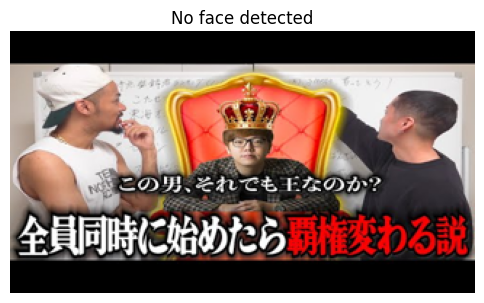

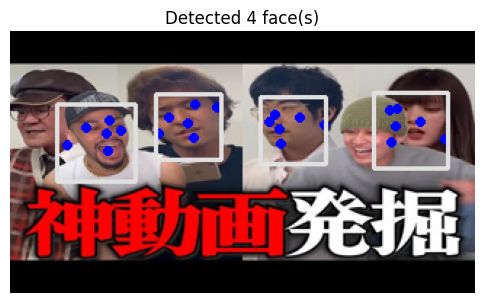

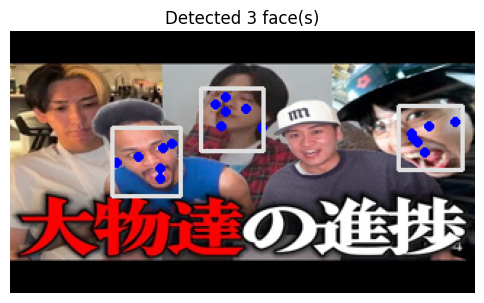

In [38]:
for i in range(3):  # 最初の3件を表示
    show_face_detection(df["thumbnail"].iloc[i])


In [40]:
# 重複列のうち「最後のものだけを残す」
df = df.loc[:, ~df.columns.duplicated(keep='last')]


In [42]:
def set_japanese_font():
    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = 'MS Gothic'  # または 'Meiryo', 'IPAexGothic'
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 日本語フォント設定完了")

set_japanese_font()


✅ 日本語フォント設定完了


📊 顔の数と再生回数の相関係数（Pearson）: 0.1682


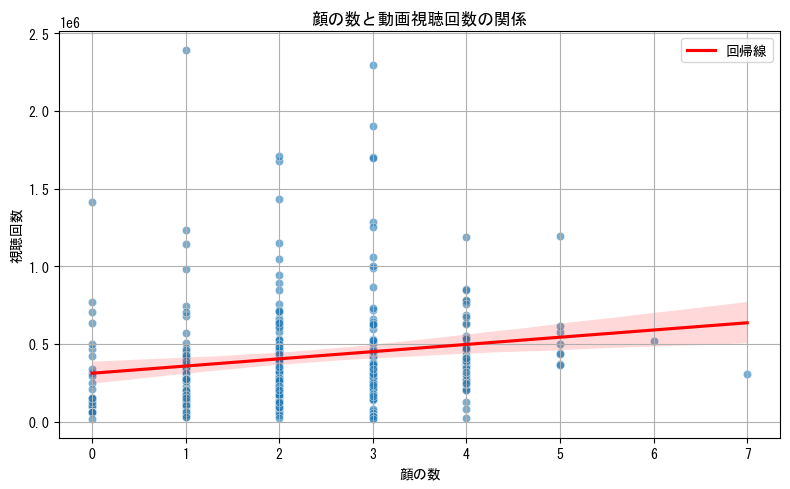

C:\Users\Owner\AppData\Local\Temp\ipykernel_54540\2877428115.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_views, x="face_count", y="viewCount", palette="viridis")


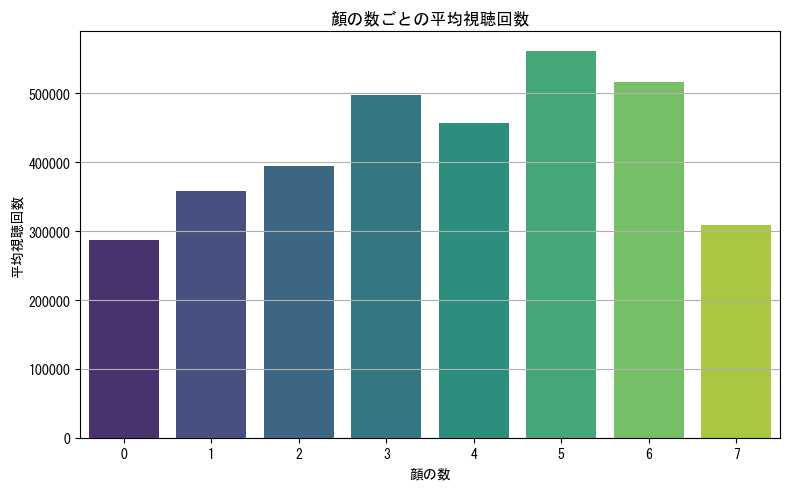

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# NaNと異常値を除外（必要に応じて）
df_clean = df[df["face_count"].notna() & df["viewCount"].notna()].copy()
df_clean["face_count"] = df_clean["face_count"].astype(int)

# 1. 顔の数ごとの平均視聴回数を集計
avg_views = df_clean.groupby("face_count")["viewCount"].mean().reset_index()

# 2. 相関係数（ピアソン相関）を計算
correlation = df_clean["face_count"].corr(df_clean["viewCount"])
print(f"📊 顔の数と再生回数の相関係数（Pearson）: {correlation:.4f}")

# 3. 散布図
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_clean, x="face_count", y="viewCount", alpha=0.6)
sns.regplot(data=df_clean, x="face_count", y="viewCount", scatter=False, color="red", label="回帰線")
plt.title("顔の数と動画視聴回数の関係")
plt.xlabel("顔の数")
plt.ylabel("視聴回数")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 平均視聴回数を棒グラフで表示
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_views, x="face_count", y="viewCount", palette="viridis")
plt.title("顔の数ごとの平均視聴回数")
plt.xlabel("顔の数")
plt.ylabel("平均視聴回数")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from janome.tokenizer import Tokenizer

# 🎯 目的変数をlog変換
df["viewCount"] = pd.to_numeric(df["viewCount"], errors="coerce").fillna(0)
y = np.log1p(df["viewCount"])

# 🔤 JanomeでTF-IDF
tokenizer = Tokenizer()
def tokenize_japanese(text):
    return [token.base_form for token in tokenizer.tokenize(text)
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']]

vectorizer = TfidfVectorizer(tokenizer=tokenize_japanese, token_pattern=None, max_features=100)
tfidf_matrix = vectorizer.fit_transform(df["title"].fillna(""))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df.index = df.index

# 🔧 投稿タイミング特徴量
timing_cols = ["weekday", "hour", "is_weekend", "is_month_start", "is_month_end"]

# 🎨 サムネイル画像特徴量カラム
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# 🧱 特徴量セット
X_base = pd.concat([
    df[["categoryId"]].reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

X_ext = pd.concat([
    df[["categoryId"] + timing_cols].reset_index(drop=True),
    tfidf_df.reset_index(drop=True)
], axis=1)

X_face = pd.concat([
    X_ext.reset_index(drop=True),
    df[["face_count"]].reset_index(drop=True)
], axis=1)

X_full = pd.concat([
    X_ext.reset_index(drop=True),
    df[thumbnail_cols].reset_index(drop=True)
], axis=1)

# 🚀 学習・評価関数
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# 📊 各モデルを評価
rmse_base = evaluate_model(X_base, y)
rmse_ext  = evaluate_model(X_ext, y)
rmse_face = evaluate_model(X_face, y)
rmse_full = evaluate_model(X_full, y)

# 📈 結果表示
print("📉 モデル精度比較（RMSE, logスケール）")
print(f"- TF-IDF + categoryId：{rmse_base:.4f}")
print(f"- + 投稿タイミング　　：{rmse_ext:.4f}")
print(f"- + 顔の数だけ追加　　：{rmse_face:.4f}")
print(f"- + 全画像特徴追加　　：{rmse_full:.4f}")


📉 モデル精度比較（RMSE, logスケール）
- TF-IDF + categoryId：0.8439
- + 投稿タイミング　　：0.8194
- + 顔の数だけ追加　　：0.8152
- + 全画像特徴追加　　：0.7636


📊 重要な特徴量TOP20：
h_mean           0.103209
s_mean           0.086003
face_count       0.053352
color_ratio_0    0.050973
telop_ratio      0.045406
tfidf_帰れる        0.042554
weekday          0.039829
tfidf_する         0.038388
tfidf_wwwww      0.031511
color_ratio_4    0.031249
color_ratio_1    0.029450
v_mean           0.023603
color_ratio_3    0.021458
tfidf_テオ         0.020751
tfidf_50         0.019809
color_ratio_2    0.019629
g_mean           0.017445
b_mean           0.015990
tfidf_なる         0.015340
r_mean           0.014884
dtype: float64


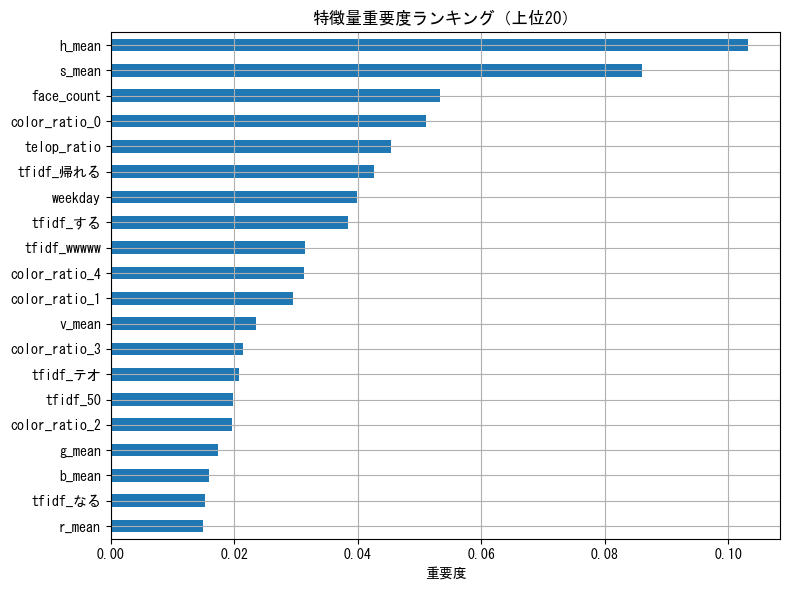

In [45]:
# 再学習（X_fullで）し、特徴量重要度を可視化
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_full, y)

# 特徴量重要度取得
importances = model.feature_importances_
feature_names = X_full.columns

# 上位20件を表示（必要に応じて調整）
top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

# 表形式でも表示
print("📊 重要な特徴量TOP20：")
print(top_features)

# グラフ表示
plt.figure(figsize=(8, 6))
top_features.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("特徴量重要度ランキング（上位20）")
plt.xlabel("重要度")
plt.tight_layout()
plt.grid(True)
plt.show()


,実際の再生回数,予測された再生回数
0,702550,280693
1,979737,384642
2,108720,298251
3,246151,244873
4,331863,227809
5,65764,170650
6,94754,189909
7,637747,366375
8,447734,257836
9,502073,332814


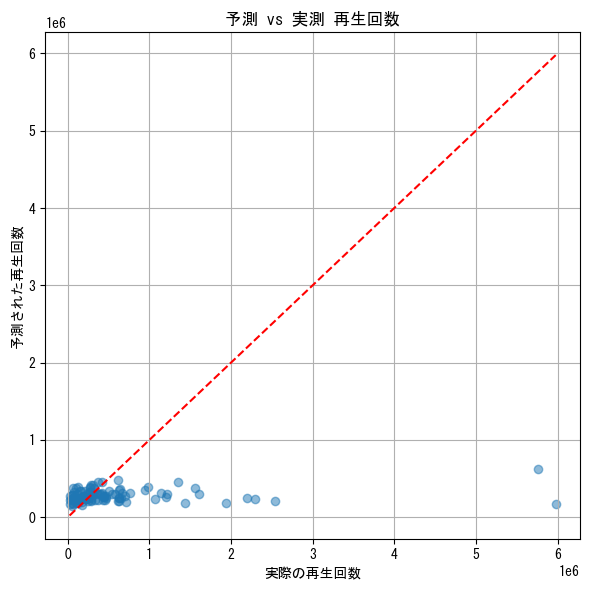

In [48]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 🎯 log変換された目的変数（再生回数）
y = np.log1p(df["viewCount"])

# ✅ 特徴量（X_full）を構成している場合：
# X_full = ... が定義済みである前提（モデル学習で使ったもの）

# 🚀 データ分割 & モデル学習
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 🔮 予測（logスケール → 再生回数に戻す）
y_pred_log = model.predict(X_test)
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# 📊 実測と予測の比較表（修正済）
result_df = pd.DataFrame({
    "実際の再生回数": y_test_actual.astype(int).values,
    "予測された再生回数": y_pred_actual.astype(int)  # ← .values 削除
}).reset_index(drop=True)

# 🖥 表示（上位20件）
display(result_df.head(20))


# 📈 散布図（オプション）
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("実際の再生回数")
plt.ylabel("予測された再生回数")
plt.title("予測 vs 実測 再生回数")
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
「予測誤差が大きい動画」のランキング出力

SyntaxError: invalid character '「' (U+300C) (1848987237.py, line 1)

In [50]:
import pandas as pd

# 📊 実測と予測の比較表を作成（再定義）
result_df = pd.DataFrame({
    "実際の再生回数": y_test_actual.astype(int),
    "予測された再生回数": y_pred_actual.astype(int)
}).reset_index(drop=True)

# 🔍 誤差と誤差率を計算
result_df["誤差"] = (result_df["予測された再生回数"] - result_df["実際の再生回数"]).abs()
result_df["誤差率（%）"] = 100 * result_df["誤差"] / result_df["実際の再生回数"]

# 📈 誤差が大きい順に並べて上位20件表示
largest_errors = result_df.sort_values(by="誤差", ascending=False).head(20).reset_index(drop=True)

# 表示
display(largest_errors)


,実際の再生回数,予測された再生回数,誤差,誤差率（%）
0,5977812,172337,5805475,97.117056
1,5761583,617273,5144310,89.286399
2,2533483,216152,2317331,91.468188
3,2294329,238473,2055856,89.605981
4,2197543,250212,1947331,88.614011
5,1937691,186498,1751193,90.375246
6,1611348,294612,1316736,81.716426
7,1436010,180121,1255889,87.456842
8,1560917,378447,1182470,75.754829
9,1197295,258784,938511,78.385945


In [54]:
pip install dlib


  Using cached dlib-20.0.0.tar.gz (3.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build dlib
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [75 lines of output]
  running bdist_wheel
  running build
  running build_ext
  <string>:163: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  Building extension for Python 3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]
  Invoking CMake setup: 'cmake C:\Users\Owner\AppData\Local\Temp\pip-install-fntub937\dlib_571df15df83e4fcc9feaa6889c0d6314\tools\python -DCMAKE_LIBRARY_OUTPUT_DIRECTORY=C:\Users\Owner\AppData\Local\Temp\pip-install-fntub937\dlib_571df15df83e4fcc9feaa6889c0d6314\build\lib.win-amd64-cpython-310 -DPYTHON_EXECUTABLE=C:\Users\Owner\anaconda3\envs\JN\python.exe -DDLIB_USE_FFMPEG=OFF -DCMAKE_LIBRARY_OUTPUT_DIRECTORY_RELEASE=C:\Users\Owner\AppData\Local\Temp\pip-install-fntub937\dlib_571df15df83e4fcc9feaa6889c0d6314\build\lib.win-amd64-cpython-310 -A x64'
  -- Building for: Ninja
  CMake Error at CMakeLists.txt:5 (message